In [25]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format

# 데이터 로드
file_path = "dataset/seoul_pm10.csv"  # 데이터 파일 경로
df = pd.read_csv(file_path, encoding='cp949')

print("데이터 크기:", df.shape)
print("\n처음 5개 행:")
display(df.head())

# 기본 데이터 정보 확인
print("\n데이터 기간:", df['date'].min(), "~", df['date'].max())
print("총 관측 수:", len(df))
print("지역 수:", df['area'].nunique())
print("\n결측치 개수:")
display(df.isnull().sum())

# 데이터 전처리
# 날짜 변환
df['date'] = pd.to_datetime(df['date'])

# 결측치 처리
df['pm10'] = df['pm10'].fillna(df['pm10'].mean())
df['pm2.5'] = df['pm2.5'].fillna(df['pm2.5'].mean())

# 시간 관련 피처 추가
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

# 지역 원-핫 인코딩
df_encoded = pd.get_dummies(df, columns=['area'], prefix='area')

# 전처리된 데이터 확인
print("\n전처리된 데이터 샘플:")
display(df_encoded.head())

# PM10 모델 학습
features_pm10 = ['pm2.5', 'hour', 'day_of_week', 'month'] + [col for col in df_encoded.columns if col.startswith('area_')]
X_pm10 = df_encoded[features_pm10]
y_pm10 = df_encoded['pm10']

# PM2.5 모델 학습
features_pm25 = ['pm10', 'hour', 'day_of_week', 'month'] + [col for col in df_encoded.columns if col.startswith('area_')]
X_pm25 = df_encoded[features_pm25]
y_pm25 = df_encoded['pm2.5']

# 데이터 분할
X_train_pm10, X_test_pm10, y_train_pm10, y_test_pm10 = train_test_split(X_pm10, y_pm10, test_size=0.2, random_state=42) #0.2가기준이라한거니 바꿔보면서 연습
X_train_pm25, X_test_pm25, y_train_pm25, y_test_pm25 = train_test_split(X_pm25, y_pm25, test_size=0.2, random_state=42)

# 모델 학습
model_pm10 = LinearRegression()
model_pm25 = LinearRegression()

model_pm10.fit(X_train_pm10, y_train_pm10)
model_pm25.fit(X_train_pm25, y_train_pm25)

# 모델 평가
y_pred_pm10 = model_pm10.predict(X_test_pm10)
y_pred_pm25 = model_pm25.predict(X_test_pm25)

print("\nPM10 모델 성능:")
print(f"R² Score: {r2_score(y_test_pm10, y_pred_pm10):.4f}")
print(f"MSE: {mean_squared_error(y_test_pm10, y_pred_pm10):.4f}")

print("\nPM2.5 모델 성능:")
print(f"R² Score: {r2_score(y_test_pm25, y_pred_pm25):.4f}")
print(f"MSE: {mean_squared_error(y_test_pm25, y_pred_pm25):.4f}")

# 2023년 1월 1일 예측을 위한 함수
def create_prediction_data(area):
    predictions = []
    for hour in range(24):
        pred_data = {
            'hour': hour,
            'day_of_week': 6,  # 2023년 1월 1일은 일요일
            'month': 1
        }

        # 지역 원-핫 인코딩 추가
        for area_col in [col for col in df_encoded.columns if col.startswith('area_')]:
            pred_data[area_col] = 1 if area_col == f'area_{area}' else 0

        predictions.append(pred_data)

    return pd.DataFrame(predictions)

# 사용자 입력 - 지역 선택
areas = sorted(df['area'].unique())
print("\n예측 가능한 지역:")
display(areas)

# 예시로 한 지역 선택 (실제로는 사용자가 선택)
selected_area = areas[5]  # 첫 번째 지역 선택
print(f"\n선택된 지역: {selected_area}")




데이터 크기: (227759, 4)

처음 5개 행:


,date,area,pm10,pm2.5
0,2022-12-31 23:00,강남구,57.00,44.00
1,2022-12-31 23:00,강동구,68.00,55.00
2,2022-12-31 23:00,강북구,59.00,42.00
3,2022-12-31 23:00,강서구,62.00,40.00
4,2022-12-31 23:00,관악구,57.00,38.00



데이터 기간: 2022-01-01 0:00 ~ 2022-12-31 9:00
총 관측 수: 227759
지역 수: 26

결측치 개수:


date        0
area        0
pm10     4916
pm2.5    4247
dtype: int64


전처리된 데이터 샘플:


,date,pm10,pm2.5,hour,day_of_week,month,area_강남구,area_강동구,area_강북구,area_강서구,...,area_성북구,area_송파구,area_양천구,area_영등포구,area_용산구,area_은평구,area_종로구,area_중구,area_중랑구,area_평균
0,2022-12-31 23:00:00,57.00,44.00,23,5,12,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2022-12-31 23:00:00,68.00,55.00,23,5,12,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2022-12-31 23:00:00,59.00,42.00,23,5,12,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,2022-12-31 23:00:00,62.00,40.00,23,5,12,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,2022-12-31 23:00:00,57.00,38.00,23,5,12,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False



PM10 모델 성능:
R² Score: 0.6079
MSE: 198.3575

PM2.5 모델 성능:
R² Score: 0.6136
MSE: 73.9499

예측 가능한 지역:


['강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구',
 '평균']


선택된 지역: 광진구


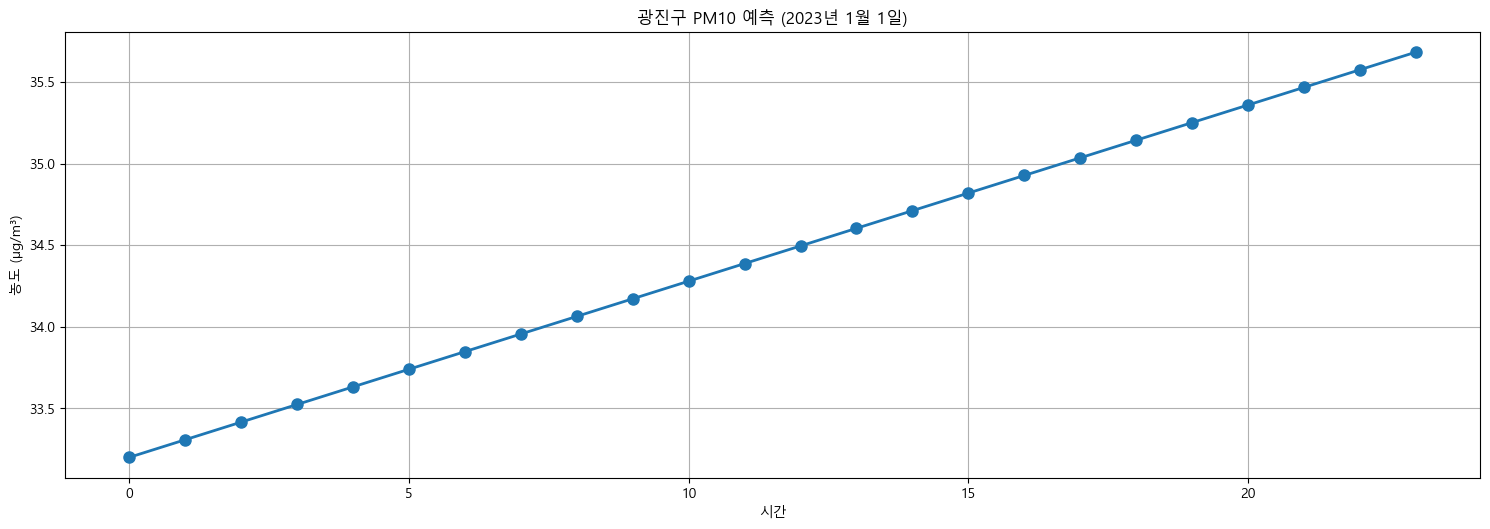

In [30]:
# 2023년 1월 1일 예측
future_data = create_prediction_data(selected_area)
pm10_predictions = []
pm25_predictions = []

# 반복 예측 (PM10과 PM2.5 상호 의존성 처리)
for hour in range(24):
    hour_data = future_data.iloc[[hour]].copy()

    # 초기값 설정
    hour_data['pm2.5'] = df['pm2.5'].mean()
    hour_data['pm10'] = df['pm10'].mean()

    # 반복 예측으로 정확도 향상
    for _ in range(3):
        pm10_pred = model_pm10.predict(hour_data[features_pm10])
        pm25_pred = model_pm25.predict(hour_data[features_pm25])

        hour_data['pm10'] = pm10_pred
        hour_data['pm2.5'] = pm25_pred

    pm10_predictions.append(pm10_pred[0])
    pm25_predictions.append(pm25_pred[0])\

# 예측 결과 시각화
plt.figure(figsize=(15, 10))

# PM10 그래프
plt.subplot(2, 1, 1)
plt.plot(range(24), pm10_predictions, marker='o', linewidth=2, markersize=8)
plt.title(f'{selected_area} PM10 예측 (2023년 1월 1일)')
plt.xlabel('시간')
plt.ylabel('농도 (μg/m³)')
plt.grid(True)
plt.tight_layout()
plt.show()

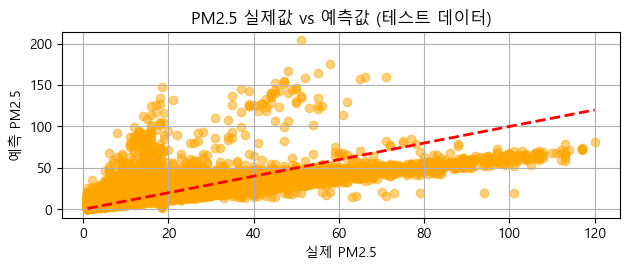

In [31]:
# PM2.5 비교
plt.subplot(2, 1, 2)
plt.scatter(y_test_pm25, y_pred_pm25, alpha=0.5, color='orange')
plt.plot([y_test_pm25.min(), y_test_pm25.max()],
         [y_test_pm25.min(), y_test_pm25.max()],
         'r--', lw=2)
plt.xlabel('실제 PM2.5')
plt.ylabel('예측 PM2.5')
plt.title('PM2.5 실제값 vs 예측값 (테스트 데이터)')
plt.grid(True)
plt.tight_layout()
plt.show()